In [117]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [118]:
np.random.seed(42)

# Portfolio Planner

In this activity, you will use the Alpaca api to grab historical data for a 60/40 portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [119]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# api = tradeapi.REST()
api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [120]:
list_of_tickers = ["SPY", "AGG"]
# YOUR CODE HERE
timeframe='1D'
start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()
#end_date = datetime.now()
#start_date = end_date + timedelta(-365)
df = api.get_barset(
    list_of_tickers,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

df.sort_index(inplace=True)
df.drop(columns=['open', 'high', 'low', 'volume'], level=1, inplace=True)
df.index = df.index.date
df = df.droplevel(axis=1, level=1)
df

,AGG,SPY
2019-01-02,106.585,249.89
2019-01-03,107.020,244.46
2019-01-04,106.695,252.41
2019-01-07,106.470,254.40
2019-01-08,106.420,256.65
...,...,...
2019-12-24,112.375,321.26
2019-12-26,112.480,322.91
2019-12-27,112.620,322.86
2019-12-30,112.630,321.10


# Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:
1. Calculate the daily returns for the SPY and AGG closing prices.
2. Calculate volatility for both the SPY and AGG closing prices.
3. Find the last day's closing price for both stocks and save those as variables.
4. Run a Monte Carlo Simulation of at least 500 iterations and generate at least 30 years of closing prices

### HINTS:
There are 252 trading days per year, so the number of records to generate for each Monte Carlo run will be 252 days * 30 years

In [121]:
daily_returns=df.pct_change()
daily_returns.head()

,AGG,SPY
2019-01-02,NaN,NaN
2019-01-03,0.004081,-0.021730
2019-01-04,-0.003037,0.032521
2019-01-07,-0.002109,0.007884
2019-01-08,-0.000470,0.008844


In [122]:
# Calculate the daily roi for the stocks
# YOUR CODE HERE
avg_daily_return_agg=daily_returns.mean()['AGG']
avg_daily_return_spy=daily_returns.mean()['SPY']


In [123]:
# Calculate volatility
# YOUR CODE HERE
std_agg=daily_returns.std()['AGG']
std_spy=daily_returns.std()['SPY']

In [124]:
# Save the last day's closing price
# YOUR CODE HERE
last_day_closing_price_agg=df.iloc[-1][0]
last_day_closing_price_spy=df.iloc[-1][1]

In [125]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30
monte_carlo = pd.DataFrame()
simulated_price_df = pd.DataFrame()

In [132]:
# Run the Monte Carlo Simulation
for x in range(number_simulations):
    simulation_prices_agg=[last_day_closing_price_agg]
    simulation_prices_spy=[last_day_closing_price_spy]
    for i in range(number_records):  
         price_agg=simulation_prices_agg[-1] * (1 + np.random.normal(avg_daily_return_agg,std_agg))
         price_spy=simulation_prices_spy[-1] * (1 + np.random.normal(avg_daily_return_spy,std_spy))
         simulation_prices_agg.append(price_agg)
         simulation_prices_spy.append(price_spy)
   

    simulated_price_df['AGG prices']=pd.Series(simulation_prices_agg)
    simulated_price_df['SPY prices']=pd.Series(simulation_prices_spy)
    
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns=simulated_price_df.pct_change()
    
    weights = [0.40, 0.60]

    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    protfolio_daily_returns=simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    monte_carlo[x]=(1+protfolio_daily_returns.fillna(0)).cumprod()

# Print records from the DataFrame

monte_carlo.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.996843,0.999008,0.995367,1.000397,1.012342,1.010130,0.996505,1.000728,1.010624,1.012491,...,0.998483,1.007499,1.010418,1.003011,0.991617,0.996755,1.007783,1.002387,0.994367,0.997020
2,0.999043,0.999023,0.996191,1.005302,1.008838,1.006938,0.995247,0.998291,1.019183,1.008017,...,1.001570,1.007129,1.013537,1.013081,0.994618,0.989905,1.013994,1.000732,0.994951,1.008901
3,0.993967,0.997018,0.996815,1.006736,1.010269,1.012935,0.994629,1.000372,1.023059,1.006325,...,1.006876,1.007427,1.015807,1.009253,0.984449,0.998608,1.016250,0.996268,1.004078,1.013796
4,1.001468,0.993933,0.995279,1.011144,1.005964,1.020848,1.000627,0.992155,1.026935,1.009788,...,1.008473,1.017659,1.024720,1.016192,0.986391,1.006905,1.017387,0.995823,1.002471,1.010662


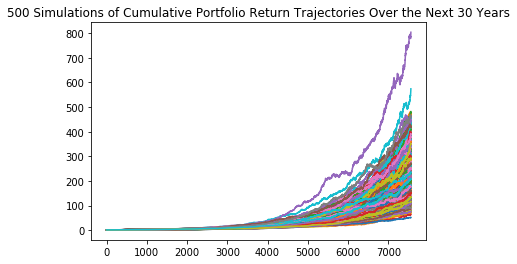

In [127]:
# Visualize the Simulation
# YOUR CODE HERE
plot_title = f"{x+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next 30 Years"
monte_carlo.plot(legend=None, title=plot_title)

In [128]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
# YOUR CODE HERE
ending_cumulative_returns=monte_carlo.iloc[-1]
ending_cumulative_returns

0      192.773859
1      171.964137
2      177.998514
3      138.466715
4      175.628015
          ...    
495    421.178699
496    176.146473
497    459.009778
498    134.136899
499    207.471362
Name: 7560, Length: 500, dtype: float64

In [129]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
# YOUR CODE HERE
cumulative_returns_at_20_years=monte_carlo.iloc[-252*10]
cumulative_returns_at_20_years

0      33.444400
1      30.894657
2      27.872681
3      25.002034
4      47.062956
         ...    
495    64.597600
496    39.657759
497    73.245460
498    18.523957
499    40.018888
Name: 5041, Length: 500, dtype: float64

In [130]:
# Display the 90% confidence interval for the ending returns
# YOUR CODE HERE
confidence_interval = ending_cumulative_returns.quantile(q=[0.05, 0.95])
confidence_interval

0.05    102.825606
0.95    379.341808
Name: 7560, dtype: float64

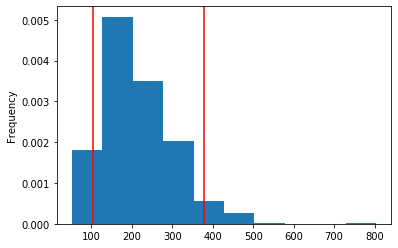

In [131]:
# Visualize the distribution of the ending returns
# YOUR CODE HERE
plt.figure();
ending_cumulative_returns.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')


---

# Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?
2. Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?
3. Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?
4. How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [109]:
# YOUR CODE HERE
ten_percentile=np.percentile(ending_cumulative_returns,10)
fifty_percentile=np.percentile(ending_cumulative_returns,50)
ninety_percentile=np.percentile(ending_cumulative_returns,90)
print(f'The 10th percentile is :{ten_percentile}')
print(f'The 50th percentile is :{fifty_percentile}')
print(f'The 90th percentile is :{ninety_percentile}')

The 10th percentile is :119.02985783731046
The 50th percentile is :199.0899699441323
The 90th percentile is :320.54983094157365


### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [110]:
# YOUR CODE HERE
initial_investment=20000
expected_portfolio_return_10th_percentile=initial_investment+(initial_investment*ten_percentile)
expected_portfolio_return_50th_percentile=initial_investment+(initial_investment*fifty_percentile)
expected_portfolio_return_90th_percentile=initial_investment+(initial_investment*ninety_percentile)
print(f'The expected portfolio return in dollars at the 10th :{expected_portfolio_return_10th_percentile}')
print(f'The expected portfolio return in dollars at the 50th :{expected_portfolio_return_50th_percentile}')
print(f'The expected portfolio return in dollars at the 90th :{expected_portfolio_return_90th_percentile}')

The expected portfolio return in dollars at the 10th :2400597.156746209
The expected portfolio return in dollars at the 50th :4001799.3988826456
The expected portfolio return in dollars at the 90th :6430996.6188314725


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

The projected yearly income :$7389 (from plaid analysis)

In [137]:
retirement_income =  .04 * (initial_investment * ending_cumulative_returns.quantile(.1))
print(retirement_income)

87733.48005460514


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [138]:
retirement_income_increase = 0.04 * (30000 * ending_cumulative_returns.quantile(.1))
print(retirement_income_increase)

131600.22008190773


### Optional Challenge

In this section, you will calculate and plot the cumulative returns for the median and 90% confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [139]:
quantile_df=monte_carlo.quantile(q=[0.05,0.5,0.95],axis=1)
investment_df=pd.DataFrame(quantile_df*20000)

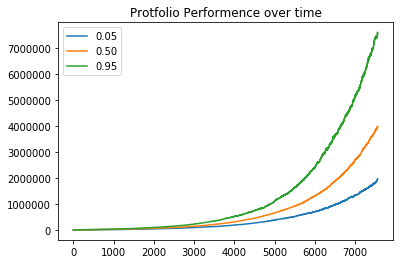

In [140]:
ax=(investment_df.iloc[0,:]).plot(title='Protfolio Performence over time')
median=(investment_df.iloc[1,:]).plot(ax=ax)
nintey=(investment_df.iloc[2,:]).plot(ax=ax)
ax.legend(['0.05','0.50','0.95']);